# Aufgabe 1
Verwendet in diesem Teil des Übungsblatts das Datenset um (mindestens) zwei Modelle zu entwickeln, um das
Versicherungsrisiko (insurance risk) von Fahrzeugen zu schätzen. Verwendet dazu zwei unterschiedliche
Regressionsansätze aus dem Repertoire von sklearn und dokumentiert euer vorgehen. Achtet dabei auf eine
saubere Trennung von Trainings- und Testdaten. Interpretiert anschließend eure Ergebnisse/Scores.

#### Wort zum Sonntag
Ich habe deine Anmerkung "Soviel wie möglich aus den bisherigen Notebooks wiederverwenden" sehr genau genommen.

## Bibliotheken

In [123]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Data-Loading
Die Daten wurden als gesamtes in dem Data-Preparation Notebook vorverarbeitet. Diese Vorverarbeiteten Daten werden nun hier geladen und entsprechend nach der jweiligen Output-Variable gesplitet.

In [124]:
df = pd.read_csv('../data/reg_df_prepared.csv',delimiter=',',encoding='utf-8', index_col=[0])
#df.info() # => Ausschließlich float64 // symboling = insurance risk = position 0


In [125]:
df.head()

,symboling,normalizedLosses,wheelBase,length,width,height,curbWeight,engineSize,bore,stroke,...,twelve,two.1,1bbl,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
0,3.0,189.409526,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,191.881529,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,167.300466,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,164.000000,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,164.000000,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## EDA & Preprocessing
Diese Schritte sind in die beiden bisher behandelten Notebooks ausgelagert. Das einzige, was in diesem Notebook gemacht wird ist die Skalierung der Daten. Das hat den Grund dass die skalierten Daten auch wieder rescaled werden müssen. Um hier dann keine Verwirrung zu stiften wird somit ausschließlich hier gescalet.

## Horizontaler & vertikaler Cut

In [126]:
input_features = list(df.columns)
in_features = list(range(1, len(input_features)))
out_feature = [0]

In [127]:
input_df = df.iloc[:,in_features]
output_df = df.iloc[:,out_feature]
inputTitles = (list(input_df.columns)) # für alle Fälle
outputTitles = (list(output_df.columns)) # für alle Fälle

In [128]:
train_X, test_X, train_y, test_y = train_test_split(
    input_df, 
    output_df,
    test_size=0.2,
    random_state = 123142
) 
len(test_X), len(test_y), len(train_X), len(train_y)

(41, 41, 164, 164)

## Skalieren

In der EDA habe ich zwar nicht wirklich Ausreißer detektiert, wähle jedoch aus meiner bisherigen Erfahrung den Robust-Scaler.

In [129]:
from sklearn.preprocessing import RobustScaler

robust_scaler_X = RobustScaler()
robust_scaler_y = RobustScaler()

robust_scaler_X.fit(train_X)
robust_scaler_y.fit(train_y)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [130]:
robust_scaled_train_X = robust_scaler_X.transform(train_X)
robust_scaled_test_X = robust_scaler_X.transform(test_X)
robust_scaled_train_y = robust_scaler_y.transform(train_y)
robust_scaled_test_y = robust_scaler_y.transform(test_y)

In [131]:
pd.DataFrame(robust_scaled_train_X, columns=input_df.columns).head(5)

,normalizedLosses,wheelBase,length,width,height,curbWeight,engineSize,bore,stroke,compressionRatio,...,twelve,two.1,1bbl,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
0,-0.532189,-0.126582,-0.425397,-0.392857,-0.282051,-0.406910,-0.259067,-0.211640,-1.174312,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.446352,-0.379747,-0.996825,-0.607143,-0.897436,-0.282790,-0.259067,-0.550265,0.146789,-1.696970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.051502,-0.050633,-0.038095,-0.035714,-0.641026,-0.011516,-0.010363,-0.253968,0.403670,-1.818182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.532189,-0.126582,-0.425397,-0.392857,-0.333333,-0.371081,-0.259067,-0.211640,-1.174312,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.098712,-0.278481,-0.260317,1.000000,-1.000000,0.468330,0.839378,1.375661,-0.880734,0.606061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Modellierung
hier mal der first Shot mit einer Linearen Regression. Ich "jage" nahezu 80 Feature in das Modell. Daher dient, das folgende nur als "first Shot". Im Anschluss erstelle ich eine PCA, und beginne das ganze von neuem.

### Helper Functions for Regression

In [132]:
def plot_pred_act(prediction, actual):
    
    r_min = actual.values.min()
    r_max = actual.values.max()
    
    red_color = '#d5042a'
    orange_color = '#ED7D31'
    blue_color = '#43bed8'
    lightgreen_color = '#98c235'
    darkgreen_color = '#0b8f6a'
    darkblue_color = '#0062A7'
    lightblue_color = '#4DBED3'    
    
    plt.figure(figsize=(8,8))
    plt.scatter(
        y=prediction,
        x=actual,
        alpha=0.2,
        marker=".",
        color=lightgreen_color
    )
    plt.xlim(r_min, r_max)
    plt.ylim(r_min, r_max)
    plt.plot([r_min, r_max], [r_min, r_max], "-", color=red_color)
    plt.title("Prediction vs Actual")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    


output_notebook()

def plot_pred_act_bokeh(prdiction, actual):

    red_color = '#d5042a'
    orange_color = '#ED7D31'
    blue_color = '#43bed8'
    lightgreen_color = '#98c235'
    darkgreen_color = '#0b8f6a'
    darkblue_color = '#0062A7'
    lightblue_color = '#4DBED3'

    r_min = actual.min()
    r_max = actual.max()

    plot = figure(
        title="Prediction accuracy",
        x_axis_label="actual",
        y_axis_label="prdiction",
        x_range=[r_min, r_max],
        y_range=[r_min, r_max]
    )
    # plot.sizing_mode = 'scale_width'


    plot.circle(
        y=prdiction.ravel(), 
        x=actual.ravel(),
        alpha=0.2,
        color=lightgreen_color
    )

    plot.line(
        x=[r_min,r_max], 
        y=[r_min,r_max],
        color=red_color
    )

    show(plot)
    
def calculate_performance(prediction, actual, scaler):
    p = scaler.inverse_transform(prediction.reshape(-1,1))
    a = scaler.inverse_transform(actual.reshape(-1,1))
    mse = mean_squared_error(p, a)
    err = np.sqrt(mse)
    r2 = r2_score(a, p)
    mae = median_absolute_error(p, a)
    
    return (mse, err, r2, mae)

def print_performance(measure_tuple):
    
    mse = measure_tuple[0]
    err = measure_tuple[1]
    r2 = measure_tuple[2]
    mae = measure_tuple[3]
    
    print("Mean squared error is {}".format(str(mse)))
    print("Positive mean error is {}".format(str(err)))
    print("Overall R² is {}".format(str(r2)))
    print("Median absolute error is {}".format(str(mae))) 

Loading BokehJS ...

# Lineare Regression

In [133]:
from sklearn.linear_model import LinearRegression

lin_regressor = LinearRegression()
lin_regressor.fit(robust_scaled_train_X, robust_scaled_train_y)
lin_regressor.score(robust_scaled_test_X, robust_scaled_test_y)

0.6178365009803053

In [134]:
lin_predicted_y = lin_regressor.predict(robust_scaled_test_X)

In [135]:
lin_measures = calculate_performance(lin_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(lin_measures)

Mean squared error is 0.6106431638113623
Positive mean error is 0.7814366025541434
Overall R² is 0.6178365009803053
Median absolute error is 0.34977775928558485


# Regression Tree

In [136]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(robust_scaled_train_X, robust_scaled_train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [137]:
tree_predicted_y = tree_regressor.predict(robust_scaled_test_X)

In [138]:
print(inputTitles[:5])

['normalizedLosses', 'wheelBase', 'length', 'width', 'height']


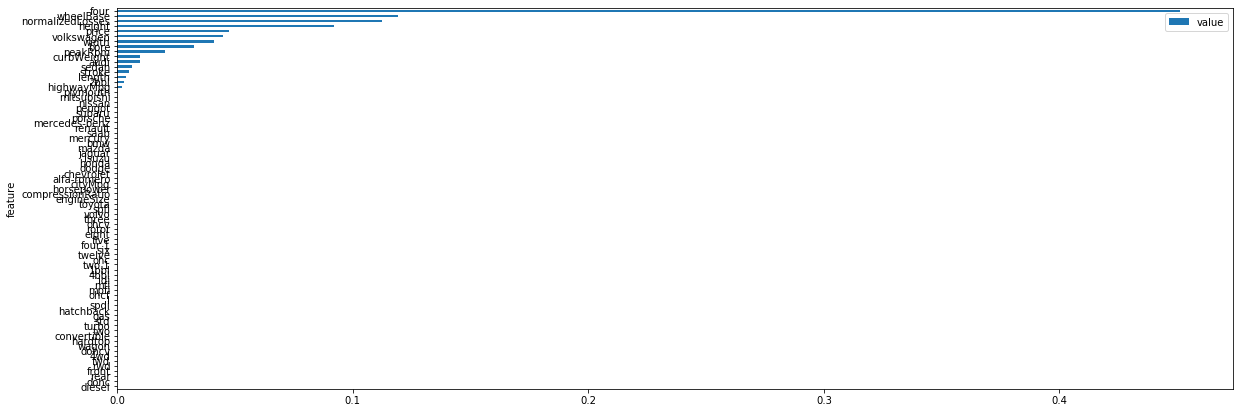

In [139]:
input_f = inputTitles
pd.DataFrame(
    {
        "value": tree_regressor.feature_importances_,
        "feature": input_f
    }
).set_index("feature").sort_values(by="value").plot(kind="barh", figsize=(20,7))

In [140]:
tree_measures = calculate_performance(tree_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(tree_measures)

Mean squared error is 0.9024390243902439
Positive mean error is 0.9499679070317291
Overall R² is 0.43521965748324654
Median absolute error is 0.0


# Polynomiale Regression

In [141]:
polynomial_feature_extractor = PolynomialFeatures(degree=2)
polynomial_feature_extractor.fit(train_X)

poly_train_data_X = polynomial_feature_extractor.transform(robust_scaled_train_X)
poly_test_data_X = polynomial_feature_extractor.transform(robust_scaled_test_X)

poly_regressor = LinearRegression()
poly_regressor.fit(poly_train_data_X, robust_scaled_train_y)

poly_predicted_y = poly_regressor.predict(poly_test_data_X)

In [142]:
poly_measures = calculate_performance(poly_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(poly_measures)

Mean squared error is 0.6951421238698299
Positive mean error is 0.8337518359019246
Overall R² is 0.5649538681216739
Median absolute error is 0.19506938926050688


# Lasso Regression

In [143]:
from sklearn.linear_model import Lasso

# small alpha --> little restriction on coefficients
lasso_regressor = Lasso(alpha=0.01, max_iter=1000)
lasso_regressor.fit(robust_scaled_train_X, robust_scaled_train_y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
lasso_predicted_y = lasso_regressor.predict(robust_scaled_test_X)

In [145]:
lasso_measures = calculate_performance(lasso_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(lasso_measures)

Mean squared error is 0.5969861972563334
Positive mean error is 0.7726488188409618
Overall R² is 0.6263835452018256
Median absolute error is 0.434580889072012


# Random Forest

In [146]:
 from sklearn.ensemble import RandomForestRegressor

forest_regressor = RandomForestRegressor(n_estimators=10)
forest_regressor.fit(robust_scaled_train_X, robust_scaled_train_y.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [147]:
forest_predicted_y = forest_regressor.predict(robust_scaled_test_X)

In [148]:
forest_measures = calculate_performance(forest_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(forest_measures)

Mean squared error is 0.4292682926829269
Positive mean error is 0.6551856932831538
Overall R² is 0.7313477289650037
Median absolute error is 0.30000000000000004


# Grid-Search Measures

In [149]:
parameter_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator = forest_regressor,
    param_grid = parameter_grid,
    cv = 3,
    n_jobs = -1,
    verbose = 0
)

grid_search.fit(robust_scaled_train_X, robust_scaled_train_y.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [150]:
gridseach_predicted_y = grid_search.best_estimator_.predict(robust_scaled_test_X)

In [151]:
gridsearch_measures = calculate_performance(gridseach_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(gridsearch_measures)

Mean squared error is 0.573327481681885
Positive mean error is 0.757183915361311
Overall R² is 0.6411900607940251
Median absolute error is 0.37009956709956726


# RandomSearchCV

In [152]:
parameter_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}

random_search = RandomizedSearchCV(
    estimator = forest_regressor,
    param_distributions = parameter_grid,
    cv = 3,
    n_jobs = -1,
    verbose = 0
)

random_search.fit(robust_scaled_train_X, robust_scaled_train_y.ravel())

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                  

In [153]:
 randomsearch_predicted_y = random_search.best_estimator_.predict(robust_scaled_test_X)

In [154]:
randomsearch_measures = calculate_performance(randomsearch_predicted_y, robust_scaled_test_y, robust_scaler_y)
print_performance(randomsearch_measures)

Mean squared error is 0.5670284805959747
Positive mean error is 0.7530129352115903
Overall R² is 0.6451322130000621
Median absolute error is 0.30465369352869365


# Evaluation

In [155]:
red_color = '#d5042a'
orange_color = '#ED7D31'
blue_color = '#43bed8'
lightgreen_color = '#98c235'
darkgreen_color = '#0b8f6a'
darkblue_color = '#0062A7'
lightblue_color = '#4DBED3'

In [156]:
models = {
    "Linear Regression": list(lin_measures),
    "Regression Tree": list(tree_measures),
    "Lasso Regression": list(lasso_measures),
    "Polynomial Regression": list(poly_measures),
    "Random Forest Regression": list(forest_measures),
    "Gridsearch Regression": list(gridsearch_measures),
    "Random Regression": list(randomsearch_measures)
}
plot_data = pd.DataFrame(models).set_index(np.array(["MSE", "Err", "R2", "MAE"])).T

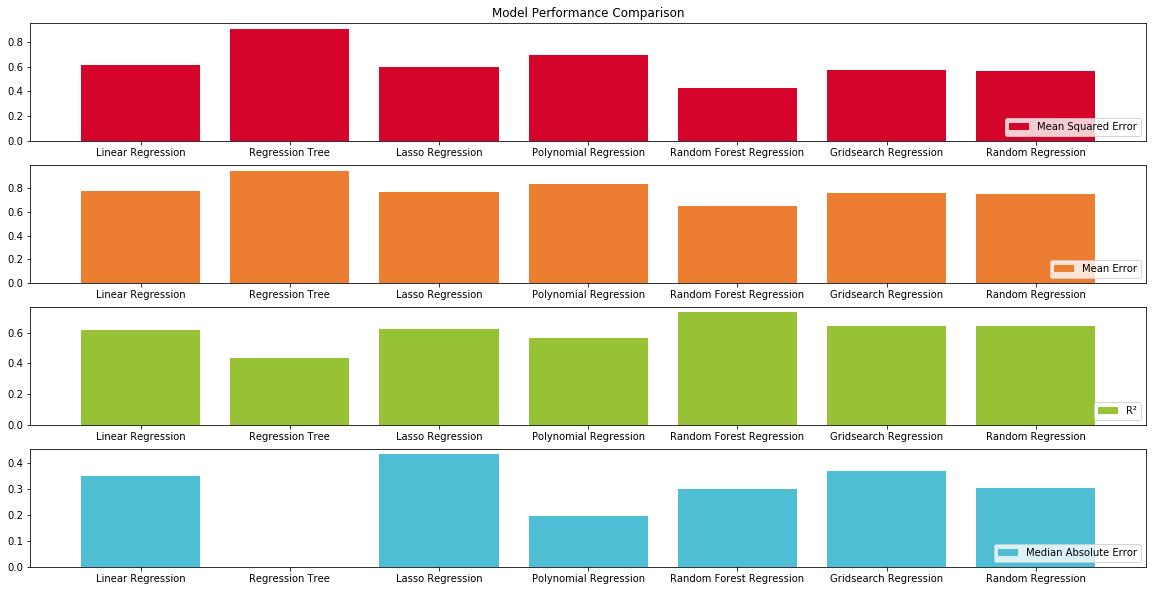

In [157]:
plt.figure(figsize=(20,10))
p1 = plt.subplot2grid((4,1), (0,0))
p2 = plt.subplot2grid((4,1), (1,0))
p3 = plt.subplot2grid((4,1), (2,0))
p4 = plt.subplot2grid((4,1), (3,0))

p1.bar(
    height=plot_data.MSE,
    x=plot_data.index,
    label="Mean Squared Error",
    color=red_color
)

p2.bar(
    height=plot_data.Err,
    x=plot_data.index,
    label="Mean Error",
    color=orange_color
)

p3.bar(
    height=plot_data.R2, 
    x=plot_data.index,
    label="R²",
    color=lightgreen_color
)

p4.bar(
    height=plot_data.MAE,
    x=plot_data.index,
    label="Median Absolute Error",
    color=lightblue_color
)

p1.set_title("Model Performance Comparison")
p1.legend(loc=4)
p2.legend(loc=4)
p3.legend(loc=4)
p4.legend(loc=4)

plt.show()

# Interpreation
Der Means Squared Error ist jener Wert, welcher Sich durch die Quadratur der Fehler(gemessen aus tatsächlichem und vorhergesagtem Wert ergibt). Je kleiner dieser Wert ist, desto eher bildet das Modell die Realität ab. Um bei der Berechnung des MSE keine Aufhebungnen der Abweichungen zu erzielen werden die Abweichungen quadriert (= Squared).  Der rooted Mean squared Error (RMSE) (hier Mean error) zieht aus dem MSE die Wurzel, wodurch dieses Kennzahl wieder zu der Datenbasis vergleichbar wird.<br>
somit sollten wir uns für das Modell mit dem kleinsten MSE entscheiden. Das ist in unserem konkreten Fall der Random-Forrest regression.
<br><br><br>
Den Mean Absolute Error berechnet den Druchschnit der absoluten Differnz zwischen Target und Prediction Punkten. Wobei alle individuellen Differenzen gleich in den Durchschnitt einfließen. Kurzum der MAE lässt sich gut verwenden, wenn der Output skalierbar ist. Bspw im Finanzbereich ist 10 das doppelte von 5. Somit ist der MAE in unserem konkreten Anwenundsbeispiel nicht sinnvoll, da die Klasse +2 nicht unbedingt "das Doppelte" der verischuerngsklasse +1 ist.
<br><br><br>
Der MSE /RMSE liefert auf den ersten Blick auf die Metric keine konkreten Hinweise auf die Qualität des Modelles. Die Metric von R2 ist dahingend im Positiven Bereich auf den wert +1 begrenzt (der Output ist immer zwischn -∞ und +1). Je besser die Qualität des Modelles, desto höher ist R2. 
Aus dieser Perspektive sollte das RF-Modell verwendet werden. 



In Absprache mit Ilona erziele ich jedoch insgesammt schlechtere Scores. Ich vermute dass mir somit während der Datenvorverarbeitung ein Fehler unterlaufen sein muss, welcher die Performance meiner Modeller derartig verschlechtert. 